#### A data science project of credit cards transactions dataset with insights, regression analysis and prediction models

This dataset is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants. The dataset was generated using Sparkov Data Generation | Github tool created by Brandon Harris. 

In [196]:
# import packages 

import pandas as pd 

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 12]

import seaborn as sns

import statsmodels.api as sm


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

The dataset has already been separated and saved in two .csv files for train and test data. However, we will concat into one data set and build own our train and test sets using randomization. 

In [197]:
# data sets:

# building dataset
temp_train = pd.read_csv('fraudTrain.csv')

# validating dataset
temp_test = pd.read_csv('fraudTest.csv')

# concating dataset into one: 
df = pd.concat([temp_train, temp_test])

In [198]:
# a peak into data
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [199]:
# number of rows and columns
df.shape

(1852394, 23)

In [200]:
## cleaning dataset ##

# rename columns
df = df.rename(columns={'trans_date_trans_time': 'Date/Time', 'cc_num':'card_num','first':'first_name','last':'last_name','dob':'DOB','trans_num':'trans_ID','is_fraud':'fraud'})

# cleaning the merchant column
df['merchant']=df['merchant'].str.replace('fraud_','')

# transforming date time
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

In [201]:
## creating a rule for reporting all fraud trans: ##

# creating a list
bool1=[]
# traversing through dataframe
for trans in df.fraud:
    if trans == 1:
        bool1.append(True)
    else:
        bool1.append(False)

# creating a panda series
bool1=pd.Series(bool1)

# creating a fraud dataframe
fraud = pd.DataFrame(df[bool1])

<ipython-input-201-edc1d800bbe4>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fraud = pd.DataFrame(df[bool1])


Some simple graphs to visualize data and pull some insights 

<AxesSubplot:>

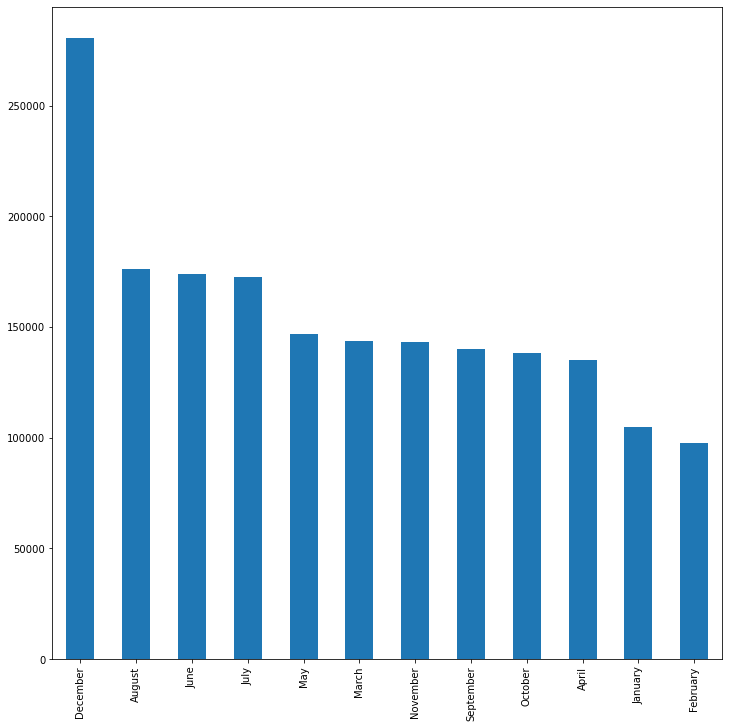

In [202]:
# transactions and months/season:

# deriving month:
df['month'] = df['Date/Time'].dt.month_name()

# plot
df['month'].value_counts().plot.bar()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud', ylabel='count'>

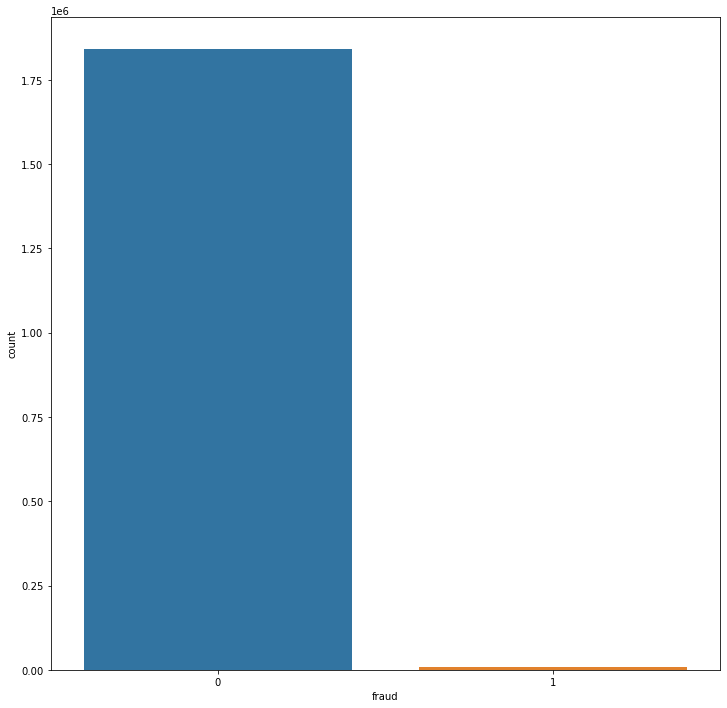

In [203]:
# visualize fraud transactions vs valid transactions
sns.countplot('fraud', data=df)

As we know from most transactional data analysis, the percentage of fraud transactions is usually low. The graph confirms this. However, a low percentage of fraud transactions makes it very difficult to classify data or build models. This is due to lack of fraud data points to achieve accuracy and validation. 

<AxesSubplot:>

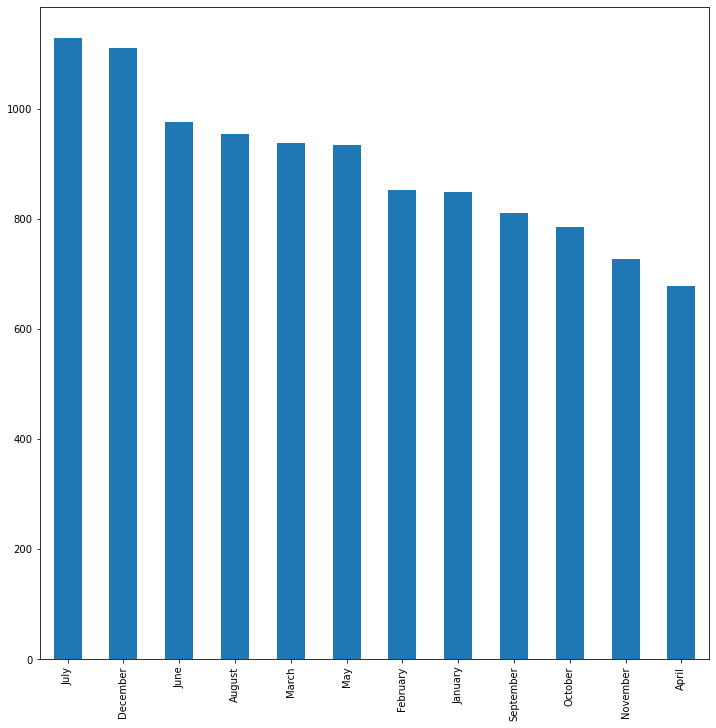

In [204]:
# fraud transactions happening per month: 

# derive month
fraud['month'] = fraud['Date/Time'].dt.month_name()
# plot
fraud['month'].value_counts().plot.bar()

Interesting! Most fraud transactions occur in March. I thought it would be December due to winter holidays season. 

In [205]:
# mean amount of fraud happening:
fraud['amt'].mean()

391.65352842653743

In [206]:
# max amount of fraud happening:
fraud['amt'].max

<bound method Series.max of 2449      281.06
2472       11.52
2523      276.31
2546        7.03
2553      275.73
           ...  
554349     60.15
554355      2.15
554390     22.49
554468     63.48
555163     27.77
Name: amt, Length: 10747, dtype: float64>

That is quite a low number for most banking transactions. The data advises that there are more small number fraud transactions than really large amounts. 

<AxesSubplot:xlabel='fraud', ylabel='count'>

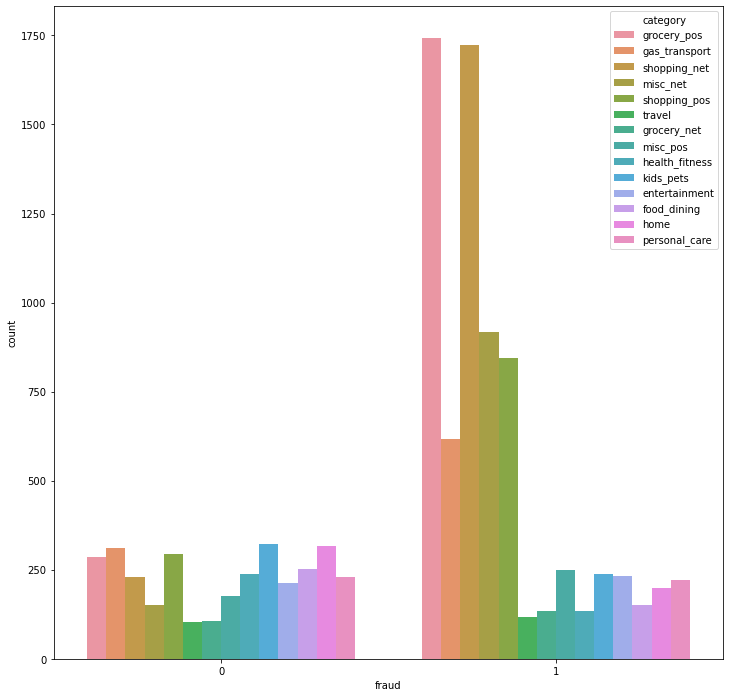

In [207]:
# fraud and category
sns.countplot(x='fraud',hue='category',data=fraud)

We can see that internet and grocery shopping has the most fraud transactions.

In [208]:
# correlation between variables 
corr = df.corr()
# plot
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Unnamed: 0,card_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,fraud
Unnamed: 0,1.000000,0.000063,0.000949,0.000370,0.000239,-0.000610,-0.000880,0.174527,0.000211,-0.000611,0.000524
card_num,0.000063,1.000000,0.001826,0.041504,-0.058744,-0.048429,-0.009118,0.000284,-0.058415,-0.048421,-0.001125
amt,0.000949,0.001826,1.000000,0.001979,-0.000670,-0.000735,0.004921,-0.002411,-0.000613,-0.000711,0.209308
zip,0.000370,0.041504,0.001979,1.000000,-0.114554,-0.909795,0.077601,0.001017,-0.113934,-0.908981,-0.002190
lat,0.000239,-0.058744,-0.000670,-0.114554,1.000000,-0.014744,-0.154816,0.000741,0.993582,-0.014709,0.002904
long,-0.000610,-0.048429,-0.000735,-0.909795,-0.014744,1.000000,-0.052359,-0.000574,-0.014585,0.999118,0.001022
city_pop,-0.000880,-0.009118,0.004921,0.077601,-0.154816,-0.052359,1.000000,-0.001636,-0.153863,-0.052329,0.000325
unix_time,0.174527,0.000284,-0.002411,0.001017,0.000741,-0.000574,-0.001636,1.000000,0.000696,-0.000571,-0.013329
merch_lat,0.000211,-0.058415,-0.000613,-0.113934,0.993582,-0.014585,-0.153863,0.000696,1.000000,-0.014554,0.002778
merch_long,-0.000611,-0.048421,-0.000711,-0.908981,-0.014709,0.999118,-0.052329,-0.000571,-0.014554,1.000000,0.000999


Better visualization if you are not a number's person: 

<AxesSubplot:>

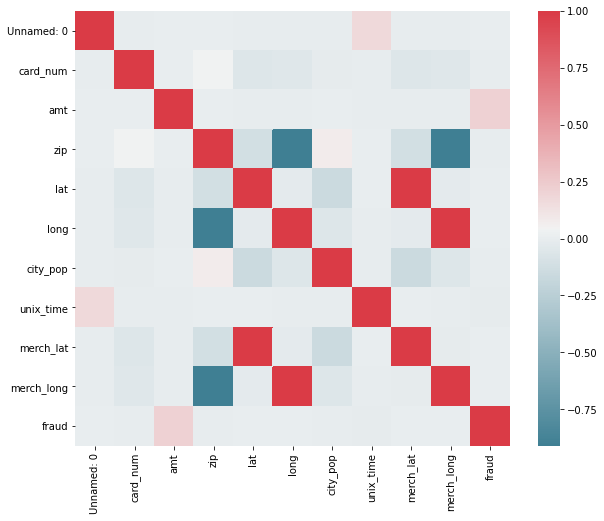

In [209]:
# plot
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The graph shows that most of the variables are not correlated. Some very common ones are like merchant's location with zip code and customer's location. 

We will do some data analysis and build some prediction models. 

For this project, we will use selective variables which we are interested in. We want to see if the chosen variables can predic if a transaction is fraud or not. The chosen variables are category, amt, gender, lat, long, city_pop, merch_lat, merch_long. We need to change these variables into binary dummy variables for our analysis. 

In [210]:
# creating dummy variables
category_d = pd.get_dummies(df['category'],drop_first=True)
gender_d = pd.get_dummies(df['gender'],drop_first=True)

# adding the new dummy ones
df = pd.concat([df,category_d,gender_d],axis=1)

In [211]:

# creating a back up
temp_df= df

# dependent variable
y = temp_df['fraud']

# easier to drop columns than name the necessary ones, predictor variable
X = temp_df.drop(['Date/Time', 'card_num', 'merchant', 'category',
       'first_name', 'last_name', 'gender', 'street', 'city', 'state', 'zip',
       'job', 'DOB', 'trans_ID', 'unix_time', 'fraud', 'month'],axis=1)

In [212]:
## Classifier using Logistic Regression ##

# split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

# implementing the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predictions
y_pred = logreg.predict(X_test)

# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

We have gotten our data to fit a model. Now, we will check for accuracy. 

In [213]:
print(confusion_matrix)

[[460447    215]
 [  2437      0]]


The confusion matrix tells us that 460447 are correct predictions, while 215 + 2437 are incorrecr predictions.

In [214]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


Let us look at some accuracy graphs. ROC is a common tool in statistical analysis concerning binary classifiers. The line represents the ROC curve of a purely random classifier; we want our classifier to be as far away from the line as possible (toward the top-left corner) to show efficiency. 

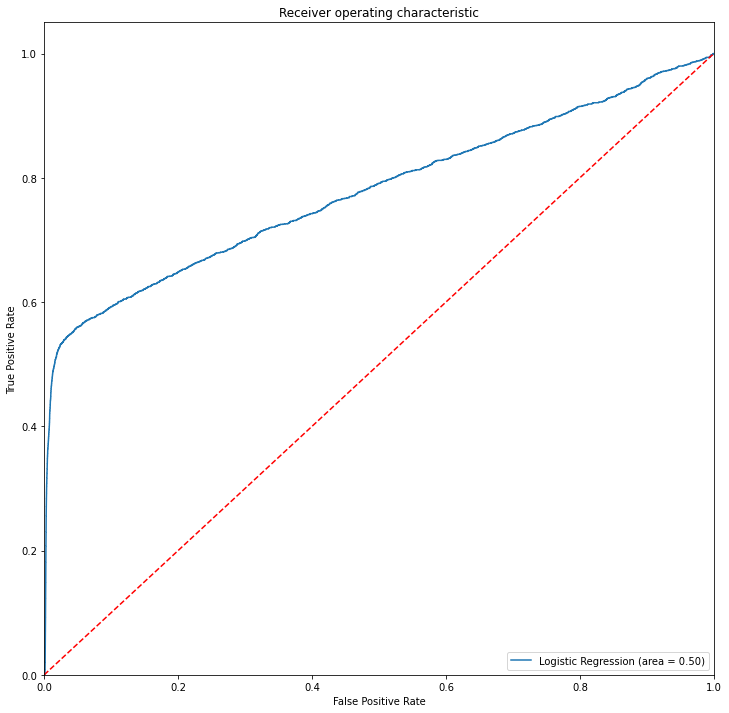

In [215]:
# ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ROC area is 0.50, it could be better. Some of the backdraws of this analysis is the data is highly imbalanced, since the difference between percentages of fraud transactions vs. valid transactions is relatively high. For next time, we would need more a stronger data set. 